In [1]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('ps', fonttype=42)

import os
sns.set(font_scale=1.25, style='whitegrid')
sns.set(palette='magma')

# rdir = '../results/'
rdir = '../results_blackbox/'
# figdir = 'figs/black-box' 
figdir = '../paper/'
# Set to path to PMLB datasets
datadir = '../datasets/pmlb/datasets/'
print('figdir:',figdir)
def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    

figdir: ../paper/


In [2]:
##########
# load results
##########
df_results = pd.read_feather('../results/black-box_results_srbench.feather')

df_results = pd.concat([pd.read_feather('../results/black-box_results_brush-cpp.feather'), df_results], axis=0)
# df_results = pd.concat([pd.read_feather('../results/black-box_results_brush_250.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_pstree.feather'), df_results], axis=0)

# df_results.reset_index()

# Removing mislabeled datasets (these are clf, but PMLB v1.0 had it as regr)
df_results = df_results[ ~df_results["dataset"].isin(["banana", "titanic"]) ]


In [3]:
df_results.columns

Index(['dataset', 'algorithm', 'random_state', 'training time (s)',
       'model_size', 'symbolic_model', 'mse_test', 'mae_test', 'r2_test',
       'params_str', 'training time (hr)', 'r2_zero_test', 'friedman_dataset',
       'symbolic_alg'],
      dtype='object')

In [4]:
print(df_results['algorithm'].unique())

df_results['algorithm'] = df_results['algorithm'].str.replace(r'^Brush$', r'Brush w/ split (no MAB)', regex=True)
df_results['algorithm'] = df_results['algorithm'].str.replace(r'^Brush wo split$', r'Brush w/o split (no MAB)', regex=True)
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush wo', r'Brush w/o'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush (', r'Brush w/ split ('))

# Short labels
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/o split (no MAB)',r'$Brush_0$'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (no MAB)','Brush+S'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/o split (D-UCB1)','Brush+M'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (D-UCB1)','Brush+SM'))

print(df_results['algorithm'].unique())

['PS-Tree' 'Brush-cpp-dynamic' 'Brush-cpp-thompson' 'Brush-cpp' 'AdaBoost'
 'AFP' 'AIFeynman' 'BSR' 'DSR' 'EPLEX' 'FEAT' 'AFP_FE' 'FFX' 'GP-GOMEA'
 'gplearn' 'ITEA' 'KernelRidge' 'LGBM' 'MLP' 'MRGP' 'Operon'
 'RandomForest' 'SBP-GP' 'Linear' 'XGB']
['PS-Tree' 'Brush-cpp-dynamic' 'Brush-cpp-thompson' 'Brush-cpp' 'AdaBoost'
 'AFP' 'AIFeynman' 'BSR' 'DSR' 'EPLEX' 'FEAT' 'AFP_FE' 'FFX' 'GP-GOMEA'
 'gplearn' 'ITEA' 'KernelRidge' 'LGBM' 'MLP' 'MRGP' 'Operon'
 'RandomForest' 'SBP-GP' 'Linear' 'XGB']


In [5]:
df_results.sample(10)

,dataset,algorithm,random_state,training time (s),model_size,symbolic_model,mse_test,mae_test,r2_test,params_str,training time (hr),r2_zero_test,friedman_dataset,symbolic_alg
4097,215_2dplanes,MLP,22118,90.900457,2402,not implemented,1.094822e+00,0.836467,0.943718,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",0.025250,0.943718,False,False
22829,659_sleuth_ex1714,AdaBoost,21575,22.833213,1454,not implemented,8.319592e+06,1599.308730,0.395929,"{'learning_rate': 0.1, 'loss': 'linear', 'n_es...",0.006343,0.395929,False,False
605,228_elusage,Brush-cpp-dynamic,5390,193.664136,40,Sub(-1.38*Cos(Sub(-0.04*Sub(23.72*Sin(31.70*av...,1.573922e+02,10.440264,0.630512,"{'pop_size': 1000, 'max_gens': 100, 'max_stall...",0.053796,0.630512,False,False
15728,611_fri_c3_100_5,RandomForest,21575,62.018218,4964,not implemented,3.991648e-01,0.528448,0.438990,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.017227,0.438990,True,False
1211,564_fried,Brush-cpp-dynamic,21962,7506.136914,55,"Add(Sub(Add(0.29*X5,Sub(0.58*X4,1.98*Cos(0.60*...",1.119196e+00,0.843151,0.955310,"{'pop_size': 1000, 'max_gens': 100, 'max_stall...",2.085038,0.955310,False,False
1545,1193_BNG_lowbwt,FFX,5390,292.167386,1510,"-0.219 - 280*max(0,X2-2.66) * max(0,X1-2.72) +...",2.484780e+05,374.616038,0.525991,{},0.081158,0.525991,False,True
11583,589_fri_c2_1000_25,Linear,22118,0.228171,25,not implemented,6.681250e-01,0.672951,0.219474,"{'alpha': 0.01, 'average': False, 'early_stopp...",0.000063,0.219474,True,False
759,626_fri_c2_500_50,PS-Tree,22118,523.017822,533,not implemented,3.108191e-02,0.143094,0.967094,"{'height_limit': 6, 'n_pop': 25, 'n_gen': 500,...",0.145283,0.967094,True,False
22913,659_sleuth_ex1714,FFX,5390,30.999490,290,"-0.0504 + 39.2*max(0,-0.798-X3) * max(0,X5-1.9...",2.806554e+06,1260.755284,0.264191,{},0.008611,0.264191,False,True
11680,590_fri_c0_1000_50,FFX,6265,1008.216007,1551,-0.114 + 0.751*X0 + 0.651*X1 + 0.515*X3 - 0.37...,6.459922e-02,0.202188,0.927252,{},0.280060,0.927252,True,True


In [6]:
def count_substrings(text, substrings):
    counts = {substring: text.count(substring+'(') for substring in substrings}

    return counts


for brush in [
    'Brush+S',   # 'Brush',
    '$Brush_0$', # 'Brush wo split',
    'Brush+M',   # 'Brush wo split (D-UCB1)',
    'Brush+SM',  # "Brush (D-UCB1)",
    'Brush-cpp',
    'Brush-cpp-thompson',
    'Brush-cpp-dynamic',
]:
    df_aux = df_results[df_results['algorithm']==brush]

    # Using only friedman or non-friedman
    # df_aux = df_aux[df_aux.dataset.str.contains("_fri_")]
    
    # display(df_aux['symbolic_model'].values[0])

    text = "ababababa"
    substrings = [
        #"Add", "Sub", "Mul", "Div", "Aq", "Abs",
        "Acos", "Asin", "Atan", "Cos", "Cosh", "Sin", "Sinh", "Tan", "Tanh",
        # "Ceil", "Floor", 
        # "Exp", "Log",
        # "Logabs", "Log1p", "Sqrt", "Sqrtabs", "Square", "Pow", "Logistic"
    ]

    tot = 0
    for idx, row in df_aux.iterrows():
        counts = count_substrings(row['symbolic_model'], substrings)

        tot += sum([v for k,v in counts.items()])

    print(brush, tot)

Brush+S 0
$Brush_0$ 0
Brush+M 0
Brush+SM 0
Brush-cpp 4277
Brush-cpp-thompson 3887
Brush-cpp-dynamic 3993


In [7]:
# df_results = df_results[df_results.dataset.str.contains("_fri_")]
    
for brush in [
    'Brush+S', # 'Brush',
    '$Brush_0$', # 'Brush wo split',
    'Brush+M', # 'Brush wo split (D-UCB1)',
    'Brush+SM', # "Brush (D-UCB1)",
    'Brush-cpp',
    'Brush-cpp-thompson',
    'Brush-cpp-dynamic',
]:
    df_aux = df_results[
        (df_results['algorithm']==brush)
        & (df_results['symbolic_model'].str.contains("If"))
    ]
    
    try:
        perc = df_aux.shape[0]/df_results[df_results['algorithm']==brush].shape[0]
        print(brush, df_aux.shape[0], perc)
    except ZeroDivisionError:
        print("Split nodes were not used")

Split nodes were not used
Split nodes were not used
Split nodes were not used
Split nodes were not used
Brush-cpp 300 0.2597402597402597
Brush-cpp-thompson 208 0.17869415807560138
Brush-cpp-dynamic 228 0.19655172413793104


In [8]:
frames = []
for brush in [
    'Brush+S', # 'Brush',
    '$Brush_0$', # 'Brush wo split',
    'Brush+M', # 'Brush wo split (D-UCB1)',
    'Brush+SM', # "Brush (D-UCB1)",
    'Brush-cpp',
    'Brush-cpp-thompson',
    'Brush-cpp-dynamic',
]:
    df_brush_sm = df_results[
        (df_results['algorithm']==brush)
        & (df_results['symbolic_model'].str.contains("If"))
    ][['dataset', 'r2_test', 'mse_test', 'symbolic_model']]

    frames.append(df_brush_sm)
    df_brush_sm.to_csv(f"./inspecting_models_{brush}.csv")

    with pd.option_context('display.max_rows', None):
        display( (df_brush_sm.groupby(['dataset']).size()/10).sort_values(ascending=False) )

    with pd.option_context('display.max_colwidth', None):
        display(df_brush_sm)

Series([], dtype: float64)

,dataset,r2_test,mse_test,symbolic_model


Series([], dtype: float64)

,dataset,r2_test,mse_test,symbolic_model


Series([], dtype: float64)

,dataset,r2_test,mse_test,symbolic_model


Series([], dtype: float64)

,dataset,r2_test,mse_test,symbolic_model


dataset
1203_BNG_pwLinear                1.0
1030_ERA                         1.0
229_pwLinear                     1.0
215_2dplanes                     1.0
1028_SWD                         0.9
659_sleuth_ex1714                0.9
665_sleuth_case2002              0.8
485_analcatdata_vehicle          0.8
228_elusage                      0.8
1027_ESL                         0.8
192_vineyard                     0.7
207_autoPrice                    0.7
nikuradse_1                      0.7
1029_LEV                         0.7
706_sleuth_case1202              0.6
621_fri_c0_100_10                0.6
687_sleuth_ex1605                0.6
678_visualizing_environmental    0.6
542_pollution                    0.6
635_fri_c0_250_10                0.5
560_bodyfat                      0.5
547_no2                          0.5
663_rabe_266                     0.5
1096_FacultySalaries             0.5
594_fri_c2_100_5                 0.5
712_chscase_geyser1              0.5
230_machine_cpu               

,dataset,r2_test,mse_test,symbolic_model
20,1027_ESL,0.837912,0.298302,"Sub(Sub(0.30*Add(1.02*Sqrt(Exp(in3)),-0.66),If(in3>0.15,0.34*in2,Mul(1.93*Tanh(-0.20*in3),Exp(in1)))),Sub(-0.38*Sub(in4,Sin(in2)),2.50*Tanh(Sub(0.11*Add(in1,2.81*in2),Mul(in2,-0.07*in4)))))"
21,1027_ESL,0.891770,0.223215,"Add(Add(If(in2>2.20,in1,0.21*in1),0.40*in4),0.20*Add(Add(in2,Mul(0.50*Sin(1.20*in1),Sub(1.59*in4,1.08*in2))),1.56*in3))"
22,1027_ESL,0.890655,0.243697,"Sub(0.11*Add(If(in3>0.12,Cos(2.03*in4),Add(2.00*in2,-0.35*in4)),3.19*Add(1.00*Sin(0.64*Add(in1,0.27*in1)),0.82*in3)),Sub(Add(-0.15*in2,-0.57*in4),0.09*Pow(Add(-0.86*in2,-2.66*in4),Tanh(-275.33*in1))))"
23,1027_ESL,0.847109,0.306562,"Sub(1.39*Tanh(Sub(Tanh(0.09*Sub(2.21*in2,-3.18*in3)),0.41*in4)),Sub(-0.23*Add(3.34*in4,Sub(0.53*in4,-1.02*in1)),If(in1>-3.22,-0.10*Cos(Add(1.12*in4,in1)),1.33)))"
24,1027_ESL,0.875070,0.250599,"Sub(Add(Sub(0.17*in1,Sub(-0.33*in4,Tanh(0.40*in3))),Div(in4,Sub(-0.69*Tanh(in1),2.32*Tanh(-468.40)))),Add(Div(Sub(0.06*in1,Sub(0.12*in4,0.18)),If(in1>1.98,in4,Sub(12.56,9.73*in2))),Add(Mul(Div(in3,in1),0.04*in2),Tanh(Add(0.48*in4,-0.35*in2)))))"
...,...,...,...,...
3447,nikuradse_1,0.997454,0.000062,"Add(If(r_k>-0.75,Add(-0.28*Sin(0.92*Sub(r_k,1.32*log_Re)),Add(-0.42*r_k,0.14*Pow(0.19,r_k))),0.32),Mul(Sub(-0.65*Log(Add(5.66*r_k,4.59)),-0.61*r_k),Tanh(Add(Sub(0.49,-1.30*log_Re),1.46*Exp(-0.67*r_k)))))"
3448,nikuradse_1,0.990888,0.000229,"1.28*Sub(Add(Add(Sub(0.24*Cos(-3132.41*r_k),-0.52*log_Re),2.79*Tanh(Sub(-0.54*log_Re,0.78))),If(r_k>-0.74,Sub(0.04*log_Re,-1.69),If(log_Re>-1.84,2.30,2.00))),Tanh(Sub(1.17*Mul(-0.60*log_Re,-0.51*log_Re),0.75*Sub(Sub(-1.97*r_k,0.41),-0.70*log_Re))))"
3470,nikuradse_2,0.983664,0.001264,"Add(Sub(0.63*Mul(If(log_v_k_nu>-2.07,Exp(-0.94*log_v_k_nu),-3.79*log_v_k_nu),Sin(-2.34*log_v_k_nu)),Add(0.29*Tanh(1.13*Sub(-2.63,-2.57*log_v_k_nu)),-0.04*log_v_k_nu)),-0.22)"
3471,nikuradse_2,0.981979,0.001514,"Sub(-1.15*Tanh(Sub(1.98*log_v_k_nu,-0.69)),Sub(-3.70*Tanh(1.96*Sub(log_v_k_nu,-1.63)),If(log_v_k_nu>-2.06,-2.91,-3.89)))"


dataset
215_2dplanes                        1.0
1028_SWD                            1.0
229_pwLinear                        1.0
1203_BNG_pwLinear                   1.0
659_sleuth_ex1714                   0.8
485_analcatdata_vehicle             0.7
665_sleuth_case2002                 0.7
678_visualizing_environmental       0.6
230_machine_cpu                     0.6
1027_ESL                            0.6
1030_ERA                            0.6
nikuradse_1                         0.6
228_elusage                         0.5
712_chscase_geyser1                 0.5
195_auto_price                      0.4
192_vineyard                        0.4
556_analcatdata_apnea2              0.4
706_sleuth_case1202                 0.4
519_vinnie                          0.4
561_cpu                             0.4
560_bodyfat                         0.4
648_fri_c1_250_50                   0.3
616_fri_c4_500_50                   0.3
611_fri_c3_100_5                    0.3
592_fri_c4_1000_25              

,dataset,r2_test,mse_test,symbolic_model
10,1027_ESL,0.837758,0.298584,"Sub(Sub(Sub(0.23*in1,Add(-0.24*in4,-0.36*in2)),If(in3>0.15,Sub(0.24*in2,0.32*in3),-0.08*in1)),If(in3>0.15,0.07*Sub(2.41*Mul(-0.58*in4,in2),2.26*in4),Mul(-0.12*Exp(in1),Add(in4,3.21*in3))))"
11,1027_ESL,0.887842,0.231315,"0.33*Sub(If(in2>2.20,0.58*in2,0.94*Sub(If(in1>-3.39,in3,-4.71*in4),-0.71*in1)),0.36*Sub(-1.96*in2,3.27*in4))"
13,1027_ESL,0.858975,0.282770,"Add(Sub(Mul(0.13*Sin(1.16*in1),1.00*in4),-0.23*in1),Sub(Sub(0.23*in2,Add(-0.39*in4,0.05)),If(in1>-3.22,0.60*Sin(-0.60*in3),-1.06)))"
16,1027_ESL,0.842831,0.275194,"0.30*Add(in3,0.30*Add(2.24*in1,If(in1>-3.26,0.35*Add(8.23*in2,11.62*in4),-2.21*in1)))"
17,1027_ESL,0.809593,0.337728,"2.22*Add(-0.47*Add(-0.22*in2,If(in1>-2.92,0.18*Div(0.19*in2,0.95*in3),-1.60)),Sin(Add(0.15*in3,0.10*Add(1.79*in4,in1))))"
...,...,...,...,...
3437,nikuradse_1,0.994932,0.000123,"Add(Sub(Sub(0.35*Sin(If(r_k>-0.75,0.89*r_k,-1.39*log_Re)),Div(0.41*Sub(-4751.29*log_Re,-14704.27*r_k),Add(7211.71*r_k,8154.74))),-0.32*Sin(Sub(1.47*log_Re,2.10*Sin(0.93*r_k)))),Add(-1.04*Sin(Add(-0.65*log_Re,0.87)),Sub(-0.89*log_Re,0.10*r_k)))"
3438,nikuradse_1,0.994225,0.000145,"0.86*Sub(Sub(-2.26*Cos(Add(Sub(0.68*log_Re,-26.44),-0.92*r_k)),-0.03*Exp(Add(If(r_k>-0.74,0.05*log_Re,0.29),-4.70*r_k))),Mul(Add(Sub(1.34*log_Re,-0.30*Cos(0.75*log_Re)),-0.59*Tanh(3.01*r_k)),Cos(If(r_k>-0.74,-0.85*r_k,0.46*log_Re))))"
3460,nikuradse_2,0.980472,0.001511,"Sub(Mul(0.96*Sub(Add(0.97,-0.42*log_v_k_nu),1.43*Exp(-0.77*log_v_k_nu)),0.99*Sin(If(log_v_k_nu>-2.07,Add(3.36,-2.27*log_v_k_nu),146.09))),0.25*log_v_k_nu)"
3461,nikuradse_2,0.980028,0.001678,"0.97*Sub(Add(4.95*Cos(3.24*Tanh(Add(0.52,0.52*log_v_k_nu))),0.04*Sin(1314.11*log_v_k_nu)),If(log_v_k_nu>-2.06,-4.64*Tanh(1.08*log_v_k_nu),5.04))"


dataset
229_pwLinear                        1.0
1028_SWD                            1.0
1203_BNG_pwLinear                   1.0
215_2dplanes                        1.0
659_sleuth_ex1714                   0.9
665_sleuth_case2002                 0.8
485_analcatdata_vehicle             0.8
228_elusage                         0.6
1030_ERA                            0.6
678_visualizing_environmental       0.6
192_vineyard                        0.6
605_fri_c2_250_25                   0.5
615_fri_c4_250_10                   0.5
519_vinnie                          0.5
230_machine_cpu                     0.5
560_bodyfat                         0.5
207_autoPrice                       0.5
195_auto_price                      0.5
663_rabe_266                        0.4
621_fri_c0_100_10                   0.4
523_analcatdata_neavote             0.4
542_pollution                       0.4
712_chscase_geyser1                 0.4
nikuradse_1                         0.4
1027_ESL                        

,dataset,r2_test,mse_test,symbolic_model
0,1027_ESL,0.817096,0.336611,"1.07*Sub(Sub(168.02*Sin(Sub(0.55*in4,-0.00*Add(in2,in3))),If(in3>0.15,-0.14*in4,-0.09*in1)),1.00*Sub(If(in3>0.15,-0.23*in1,-0.21*in2),Add(1477.85*Sub(Tanh(-0.21*in4),-0.15*in4),-0.31*Sin(0.56*in2))))"
3,1027_ESL,0.846598,0.307588,"Sub(Sub(-0.10*Cos(Add(1.05*in4,1.29*in1)),If(in1>-3.22,-0.23*in2,0.28*in3)),Add(Sub(in3,0.22*in1),Add(-4.63*Sin(0.30*in3),-0.39*in4)))"
6,1027_ESL,0.846212,0.269274,"Add(If(in1>-3.26,0.98*Tanh(0.32*in3),-0.24*in1),Sub(1.40*Sin(Add(Sub(-0.34*in4,-0.20*in2),0.16*in1)),-0.82*in4))"
7,1027_ESL,0.812500,0.332571,"Sub(0.65*Sub(Tanh(Sub(0.46*in1,in2)),-0.59*in4),Add(If(in1>-2.92,0.83*Sin(-0.40*in3),0.38*in3),-0.72*in2))"
30,1028_SWD,0.426432,0.394881,"0.19*Sub(0.66*Add(Add(Add(If(In3>0.25,In4,1.13*In5),1.00*Sub(In5,-0.41*In6)),In8),Sub(Sub(2.76*In3,-1.50*In10),-0.76*In7)),-0.60*In9)"
...,...,...,...,...
3424,nikuradse_1,0.996146,0.000084,"Sub(Add(If(r_k>-0.72,0.04*log_Re,0.21),0.11*Pow(0.02,r_k)),Add(0.32*Add(0.50*r_k,Tanh(Sub(2.55*r_k,1.38*log_Re))),Tanh(Add(Sub(1.23*log_Re,-1.27),0.52*Pow(0.13,r_k)))))"
3428,nikuradse_1,0.969748,0.000759,"Add(0.61*Sin(-2.03*Cos(0.43*Add(If(r_k>-0.74,1.02*r_k,8.60*r_k),-1.75*log_Re))),Sub(3.11*Tanh(56.84*Cos(Sub(0.64,7.96*r_k))),Div(-1.77*Exp(0.04*Sin(-2.15*log_Re)),Tanh(1.98*Sin(3.09*r_k)))))"
3451,nikuradse_2,0.981345,0.001567,"Sub(Add(Add(If(log_v_k_nu>-2.06,0.38*log_v_k_nu,-1.49),1.79*Cos(log_v_k_nu)),Add(3.53*Sin(-0.52*Sin(2.21*log_v_k_nu)),-1.08)),-0.97*Cos(1.00*Add(-2.24,2.75*log_v_k_nu)))"
3452,nikuradse_2,0.984930,0.000983,"4.14*Add(1.13*Cos(1.16*Add(If(log_v_k_nu>2.34,-0.29*log_v_k_nu,0.77*Cos(1.14*log_v_k_nu)),5.05*Tanh(0.12*log_v_k_nu))),-0.14*Add(Sin(-2.32*log_v_k_nu),4.91))"


In [9]:
# !pip install statannotations
# from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations
from scipy.stats import ttest_1samp 

np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))


ds = '562_cpu_small'
#for ds in ['562_cpu_small', '227_cpu_small', '1203_BNG_pwLinear', '197_cpu_act', '215_2dplanes', '229_pwLinear']:
for ds in ['649_fri_c0_500_5']:
    print(ds)

    # Filter by the selected dataset and show the best performing expressions for the algorithms
    filtered = df_results[
        (df_results['dataset']==ds)
        & (df_results['algorithm'].str.contains("Brush"))
    ]

    print(filtered.shape)

    # groupby algorithm, then find the highest value for r2_test column, and report the value in symbolic_model column for that row

    # Group by algorithm and find the row with the max r2_test within each group
    # best_performing_models = filtered.groupby('algorithm').apply(lambda x: x.loc[x['r2_test'].idxmax(), ['symbolic_model', 'r2_test', 'model_size']])
    best_performing_models = filtered.groupby('algorithm').apply(lambda x: x.loc[x['model_size'].idxmin(), ['symbolic_model', 'r2_test', 'model_size']])

    # Reset index to make 'algorithm' a regular column again
    best_performing_models.reset_index(inplace=True)
    best_performing_models['symbolic_model'] = best_performing_models['symbolic_model'].str.wrap(80)

    with pd.option_context('display.max_colwidth', None):
        wrap_df_text(best_performing_models)
        # display(best_performing_models)
        
    for col_of_interest in ['r2_test', 'model_size']:
        display(filtered.groupby('algorithm')[col_of_interest].mean())

        # 95% confidence interval
        print('confidence interval')
        for alg, dg in filtered.groupby('algorithm'):
            _, sdx, ciux, cilx = bootstrap(dg[col_of_interest].values, fn=np.median, n=1000)
            print(alg, round(ciux, 3), round(cilx, 3), round(sdx, 3), sep='\t')

        # Staistics
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
        for algorithm in filtered['algorithm'].unique():
            if algorithm == '$Brush_0$': continue

            print(algorithm, 
                ttest_1samp(
                    (filtered[filtered['algorithm']==algorithm])[col_of_interest].dropna(),
                    popmean=filtered[filtered['algorithm']=='$Brush_0$'][col_of_interest].mean(),
                    alternative='greater' if col_of_interest == 'r2_test' else 'less'
                )
            )

649_fri_c0_500_5
(30, 14)


,algorithm,symbolic_model,r2_test,model_size
0,Brush-cpp,"Sub(1.25*Add(Sub(0.22*oz5,0.68*Add(Cos(oz3),1.76)),Sin(Sub(0.57*oz1,Add(-0.84*oz2,0.10)))),Sub(Mul(Sub(-0.71*oz2,2.51),Sub(Cos(0.44*oz1),0.32*oz2)),Add(0.58*oz4,-0.28*Sin(oz2))))",0.959283,47
1,Brush-cpp-dynamic,"Sub(Add(Cos(1.00*Add(Add(0.76*oz1,0.85*oz2),-2791.24)),Sub(Sub(0.58*Add(oz4,0.59),-0.28*oz5),0.06*Exp(1.57*oz2))),0.59*Cos(1.31*oz3))",0.897321,36
2,Brush-cpp-thompson,"Add(1.92*Tanh(Add(0.49*Sin(Add(0.83*oz2,oz1)),0.31*Cos(Mul(oz2,oz1)))),Add(Sub(0.25*oz5,Add(-0.57*oz4,0.02*oz3)),-0.68*Cos(1.17*oz3)))",0.953698,37


algorithm
Brush-cpp             0.938433
Brush-cpp-dynamic     0.940785
Brush-cpp-thompson    0.948903
Name: r2_test, dtype: float64

confidence interval
Brush-cpp	0.959	0.955	0.012
Brush-cpp-dynamic	0.957	0.918	0.012
Brush-cpp-thompson	0.954	0.95	0.002
Brush-cpp-dynamic Ttest_1sampResult(statistic=nan, pvalue=nan)
Brush-cpp-thompson Ttest_1sampResult(statistic=nan, pvalue=nan)
Brush-cpp Ttest_1sampResult(statistic=nan, pvalue=nan)


algorithm
Brush-cpp             55.9
Brush-cpp-dynamic     50.6
Brush-cpp-thompson    50.9
Name: model_size, dtype: float64

confidence interval
Brush-cpp	61.5	48.0	3.873
Brush-cpp-dynamic	56.0	47.0	2.723
Brush-cpp-thompson	57.0	44.0	3.557
Brush-cpp-dynamic Ttest_1sampResult(statistic=nan, pvalue=nan)
Brush-cpp-thompson Ttest_1sampResult(statistic=nan, pvalue=nan)
Brush-cpp Ttest_1sampResult(statistic=nan, pvalue=nan)


In [10]:
frames = []
frames_without = []

for brush in [
    'Brush+S', # 'Brush',
    '$Brush_0$', # 'Brush wo split',
    'Brush+M', # 'Brush wo split (D-UCB1)',
    'Brush+SM', # "Brush (D-UCB1)",
    'Brush-cpp',
    'Brush-cpp-thompson',
    'Brush-cpp-dynamic',
]:
    print(brush)
    
    df_brush_sm = df_results[
        (df_results['algorithm']==brush)
        & (df_results['symbolic_model'].str.contains("If"))
    ][['algorithm', 'dataset', 'r2_test', 'mse_test', 'model_size', 'symbolic_model']]

    dss = df_brush_sm['dataset'].unique().tolist()
    print(len(dss), dss)

    if len(df_brush_sm) == 0:
        continue
    print("saving...")
    frames.append(df_brush_sm)
    
    df_brush_sm = df_results[
        (df_results['algorithm']==brush)
        & (~df_results['symbolic_model'].str.contains("If"))
        & (df_results['dataset'].isin(dss))
    ][['algorithm', 'dataset', 'r2_test', 'mse_test', 'model_size', 'symbolic_model']]

    frames_without.append(df_brush_sm)

Brush+S
0 []
$Brush_0$
0 []
Brush+M
0 []
Brush+SM
0 []
Brush-cpp
80 ['1027_ESL', '1028_SWD', '1029_LEV', '1030_ERA', '1089_USCrime', '1096_FacultySalaries', '1191_BNG_pbc', '1196_BNG_pharynx', '1199_BNG_echoMonths', '1203_BNG_pwLinear', '192_vineyard', '195_auto_price', '207_autoPrice', '210_cloud', '215_2dplanes', '218_house_8L', '225_puma8NH', '228_elusage', '229_pwLinear', '230_machine_cpu', '485_analcatdata_vehicle', '503_wind', '505_tecator', '519_vinnie', '522_pm10', '523_analcatdata_neavote', '529_pollen', '537_houses', '542_pollution', '547_no2', '556_analcatdata_apnea2', '557_analcatdata_apnea1', '560_bodyfat', '561_cpu', '564_fried', '574_house_16H', '579_fri_c0_250_5', '581_fri_c3_500_25', '593_fri_c1_1000_10', '594_fri_c2_100_5', '595_fri_c0_1000_10', '596_fri_c2_250_5', '601_fri_c1_250_5', '602_fri_c3_250_10', '604_fri_c4_500_10', '605_fri_c2_250_25', '609_fri_c0_1000_5', '611_fri_c3_100_5', '613_fri_c3_250_5', '615_fri_c4_250_10', '616_fri_c4_500_50', '617_fri_c3_500_5', 

With splits , friedman datasets
Without splits , friedman datasets


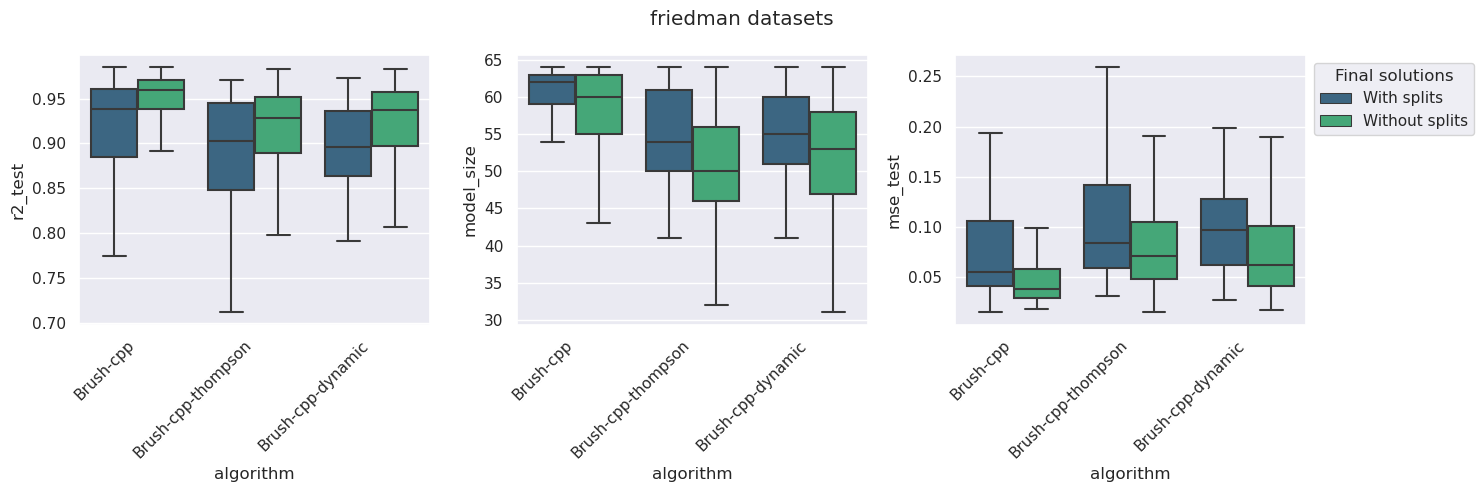

With splits , non-friedman datasets
Without splits , non-friedman datasets


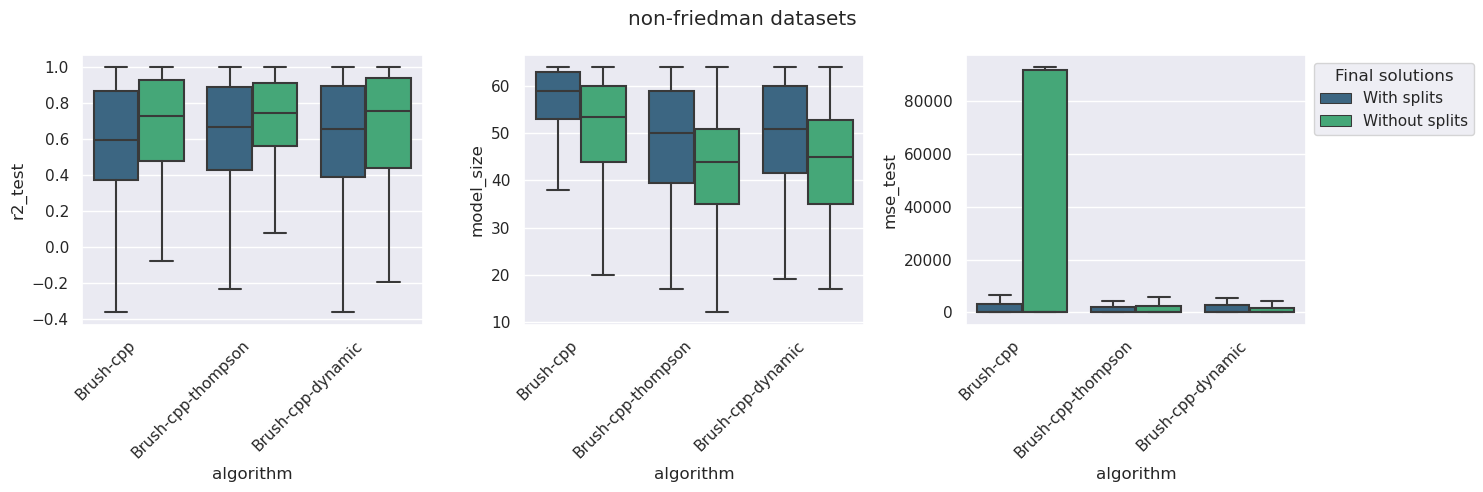

In [11]:
for fri in [True, False]:
    both = []
    for f, name in [(frames, "With splits"),
                    (frames_without, "Without splits")]:

        # Combine dataframes from both lists
        df_combined = pd.concat(f, ignore_index=True)

        if fri:
            df_combined = df_combined[df_combined.dataset.str.contains("_fri_")]
        else:
            df_combined = df_combined[~df_combined.dataset.str.contains("_fri_")]

        df_combined['Final solutions'] = name
        both.append(df_combined)

        print(name, ',', 'friedman' if fri else 'non-friedman', 'datasets')
        # display(df_combined)

        # # Create a figure with two subplots
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # sns.boxplot(x='algorithm', y='r2_test', data=df_combined, ax=axs[0], showfliers=False)
        # sns.boxplot(x='algorithm', y='model_size', data=df_combined, ax=axs[1], showfliers=False)
        # sns.boxplot(x='algorithm', y='mse_test', data=df_combined, ax=axs[2], showfliers=False)

        # axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
        # axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
        # axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')

        # # axs[0].set_ylim(0.25, 1.0)
        # # axs[1].set_ylim(10, 65)
        # # axs[2].set_ylim(0, 2)

        # # Layout so plots do not overlap
        # plt.tight_layout()

        # # Show the plot
        # plt.show()
    
    # plotting both together
    df_both = pd.concat(both, ignore_index=True)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.boxplot(x='algorithm', y='r2_test', hue='Final solutions', data=df_both, ax=axs[0], showfliers=False, palette='viridis')
    sns.boxplot(x='algorithm', y='model_size', hue='Final solutions', data=df_both, ax=axs[1], showfliers=False, palette='viridis')
    sns.boxplot(x='algorithm', y='mse_test', hue='Final solutions', data=df_both, ax=axs[2], showfliers=False, palette='viridis')

    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
    axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right')

    fig.suptitle(' '.join(['friedman' if fri else 'non-friedman', 'datasets']))
    # axs[0].set_ylim(0.25, 1.0)
    # axs[1].set_ylim(10, 65)
    # axs[2].set_ylim(0, 2)
    
    axs[0].get_legend().set_visible(False)
    axs[1].get_legend().set_visible(False)
    sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))

    # Layout so plots do not overlap
    plt.tight_layout()

    # Show the plot
    plt.show()